In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
data_path = '/mnt/share/petric/Siemens_mMR_NEMA_IQ'

In [3]:
STIR.set_verbosity(1)

In [4]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

In [5]:
def create_acq_model_and_obj_fun(acquired_data, additive_term, mult_factors, template_image):
    '''
    Create an acquisition model and objective function, corresponding to the given data.
    '''
    # We could construct this by hand here, but instead will just use `partitioner.data_partition`
    # with 1 subset, which will then do the work for us.
    num_subsets = 1
    _, acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets, initial_image=template_image)
    return (acq_models[0], obj_funs[0])

In [6]:
def rdp_step_size_den (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(sDir_ - shiftSI_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_    

In [7]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


In [8]:
# def rdp_grad_sirf (inpImm_,kappa_,eps_,pixS_):
#     rdpG_ = np.zeros_like(inpImm_)
#     for xs in range(-1,2):
#         for ys in range (-1,2):
#             for zs in range(-1,2):
#                 if (xs == 0) and (ys==0) and (zs==0): 
#                     print('continuing')
#                     continue
#                 shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
#                 sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
#                 if zs==-1:
#                     shiftImm_[-1,:,:]= inpImm_[-1,:,:]
#                 if zs==1:
#                     shiftImm_[0,:,:] = inpImm_[0,:,:]

#                 tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
#                 rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
#     return rdpG_
    

In [9]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(inpImm_ + shiftImm_ + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

In [10]:
def rdp_step_size_bis (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    pass

In [11]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))

In [12]:
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

In [13]:
stir_prior = STIR.CudaRelativeDifferencePrior ()

In [14]:
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

In [15]:
# stirG = stir_prior.gradient(image)

In [16]:
inpImage = image.as_array()

# Reconstruction

In [17]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)

In [18]:
templRed = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'),max_ring_diff=1,view_mash_factor=2)
acq_model_red = STIR.AcquisitionModelUsingParallelproj()
acq_model_red.set_up(templRed,image)

In [22]:
image.fill(ndi.gaussian_filter(inpImage,1))

NameError: name 'ndi' is not defined

# Osem

In [ ]:
sens = acq_model.backward(multCorr)

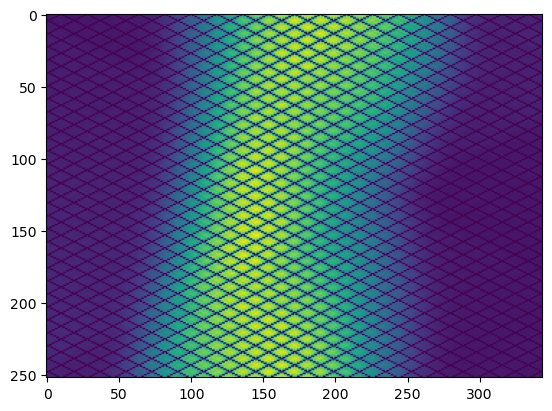

In [860]:
plt.imshow((multCorr*addCorr).as_array()[0,72,:,:])

In [866]:
nIt = 10
#
for itIdx in range(nIt):
    curFP = acq_model.forward(image)
    curFP +=addCorr
    curFP *= multCorr
    
    upF = acq_model.backward(multCorr*template/curFP)
    upF /= sens
    image *= upF

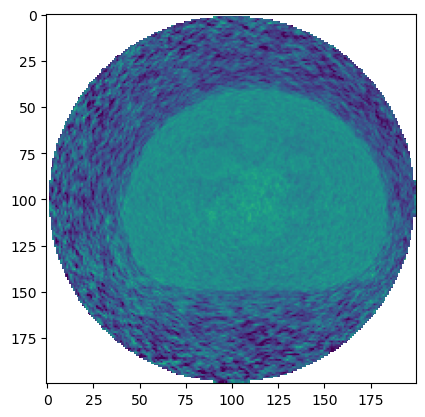

In [869]:
plt.imshow(upF.as_array()[72,:,:],vmin=.8,vmax=1.2)

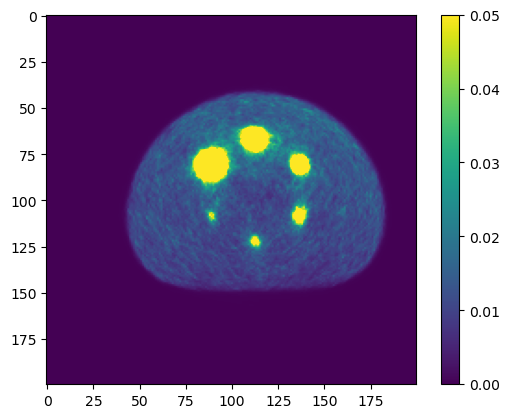

In [187]:
plt.imshow(image.as_array()[72,:,:],vmax=.05)
plt.colorbar()

(0.0, 0.35)

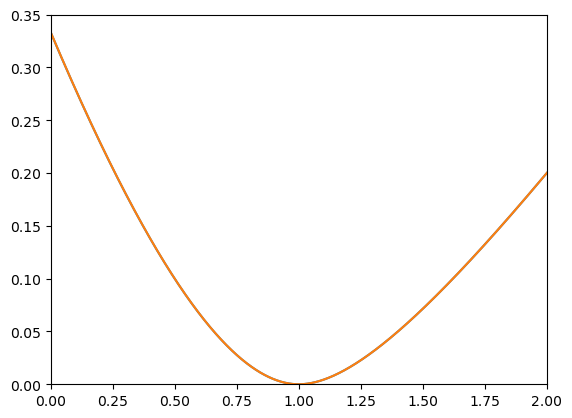

In [16]:
xv = np.arange(0,10,0.001)
yv1 = (1-xv)**2 / (1+xv + 2 * np.abs(1-xv)+1e-3)
plt.plot (xv,yv1)
yv1 = (1-xv)**2 / (1+xv + 2 * np.abs(1-xv))
plt.plot (xv,yv1)
plt.xlim(0,2)

# yv1 = (1-xv)**2 / (1+xv + 0 * np.abs(1-xv))
# plt.plot (xv,yv1)
# yv1 = (1-xv)**2 / (1+xv + 5 * np.abs(1-xv))
# plt.plot (xv,yv1)
plt.ylim((0,.35))

# PGA

## Compute diagonal preconditioner as the diagonal of the hessian 

(BP(attenuation^2))

In [19]:


tFP = acq_model.forward(image)
# tFP += addCorr
# tFP *= multCorr
# rMax = addCorr.max()* 1e-6
# tFP += rMax # add a very small number to avoid dividing by 0
myK = acq_model.backward(multCorr/tFP)

In [33]:
# UNCOMMENT and run to "restart" from the clean image

image.fill(inpImage)

In [274]:
13%10

3

The border line often has numerical instability, let alone the area outside the circle which is NaN by definition. Define a mask

In [20]:
import scipy.ndimage as ndi
mask = kappa.as_array()<1
mask = ndi.binary_dilation(mask)
mask = 1 - mask
#maskImm = STIR.ImageData(
maskS = image.get_uniform_copy(0)
maskS.fill(mask)

## Actual recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [34]:
nIt = 2000
# initialize the current estimate
#addCorr += rMax
fwdProj = acq_model.forward(image)
#fwdProj += addCorr
#fwdProj *= multCorr 
#fwdProj += rMax
recItV = np.zeros((nIt//20,) + inpImage.shape)
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)

for itIdx in range(nIt):
    gradSino =  template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    grad = gradI - stir_prior.gradient(image)

    sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1

    # Uncomment to conver to conjugate 
    
    # if itIdx>0:
    #     beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
    #     sDir += beta * prevSDir 
    # prevSDir = sDir.clone()
    # gradP = grad.clone()   

    acq_model.forward(sDir,out=fPsDir) #*multCorr

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot(fPsDir/fwdProj)
    
#    print ('num: {:.1e} den: {:.1e}'.format(ssNum,ssDen))
    ssTomo = ssNum/ssDen

    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+betaPen*penSSNum)/(ssDen+betaPen*penSSDen)

    # update image and sinogram
    image += ss*sDir
 #   fwdProj += ss*fPsDir
 #   print(ss)

# UNCOMMENT to update sinogram in each iteration
    
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)
    acq_model.forward(image,out=fwdProj)
    # ts = time.time()
    # fwdProj += addCorr 
    # t1 = time.time()
    # fwdProj *= multCorr 
    # t2 = time.time()
    if (itIdx%20)==0:
        print(itIdx)
    

  #  fwdProj+= ss/ssDen*fPsDir
        recItV[itIdx//20,:,:,:] = image.as_array()
    

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980


In [28]:
#recItV_CG = recItV.copy()
recImmCG = image.as_array()

In [276]:
help (STIR.AcquisitionModel)

Help on class AcquisitionModel in module sirf.STIR:

class AcquisitionModel(builtins.object)
 |  Class for PET acquisition model.
 |  
 |  Class for a PET acquisition model that relates an image x to the
 |  acquisition data y as
 |  
 |  (F)    y = [S] (G [P] x + [a]) + [b]
 |  
 |  where:
 |  square brackets embrace optional terms;
 |  P is an ImageDataProcessor, assumed to be the identity
 |  if not present;
 |  G is the geometric (ray tracing) projector from the image voxels
 |  to the scanner's pairs of detectors (bins);
 |  a and b are the additive and background terms representing
 |  the effects of accidental coincidences and scattering, assumed
 |  to be 0 if not present;
 |  S is the acquisition sensitivity map representing the
 |  detector (bin) efficiencies (see AcquisitionSensitivityModel),
 |  assumed to be the identity if not present.
 |  
 |  The computation of y for a given x by the above formula (F) is
 |  referred to as the forward projection, and the computation of


In [104]:
import time
#ts = time.time()
fPsDir.dot(fPsDir/(fwdProj+ss*fPsDir))/ssDen #2559751200
#,  2559751200.0
#print (ts-time.time())

0.9567885

In [126]:
upPSSN, upPSSD = rdp_step_size (inpImage,sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes(), ss/1)

In [127]:
upPSSN/penSSNum , upPSSD/penSSDen

(1.1474367224281985, 0.9755248322671446)

In [132]:
ssNum/(betaPen*penSSNum), ssDen/(betaPen*penSSDen)

(-0.025691963573068945, 0.0012032774564645745)

In [102]:
ssDen / 2559751200

1.0242227416477039

### Plot some images

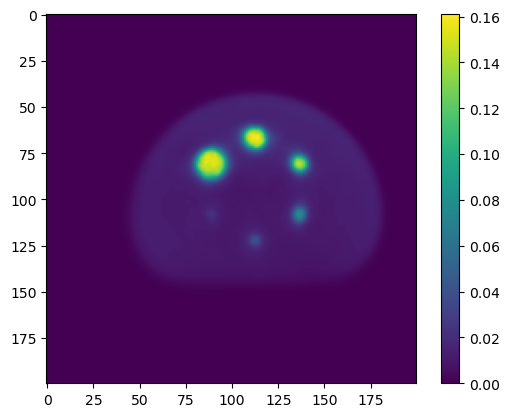

In [35]:
plt.imshow((image.as_array())[72,:,:]) #,vmax=.16)
plt.colorbar()

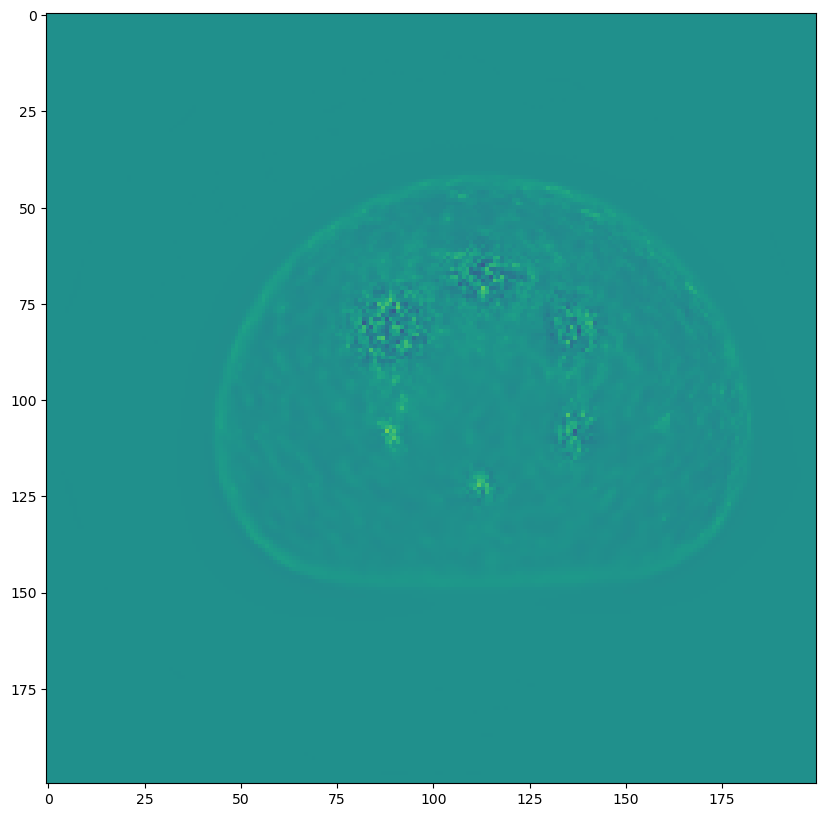

In [195]:
plt.figure(figsize=(10,10))
# plt.subplot(121)
# #plt.imshow((image.as_array())[72,:,:],vmin=0,vmax=.09)
# plt.imshow(recItV[-1,72,:,:],vmin=0,vmax=.12)
# #plt.imshow(inpImage[72,:,:]-0.004*sDirImm[72,:,:],vmin=0,vmax=.2)
# plt.subplot(122)
# plt.imshow(recItV_CG[-1,72,:,:],vmin=0,vmax=.12)
plt.imshow(recItV[9,72,:,:]-recItV_CG[9,72,:,:],vmin=-0.02,vmax=.02)

In [119]:
recItV_CG = recItV.copy()

Text(0, 0.5, 'Difference vector')

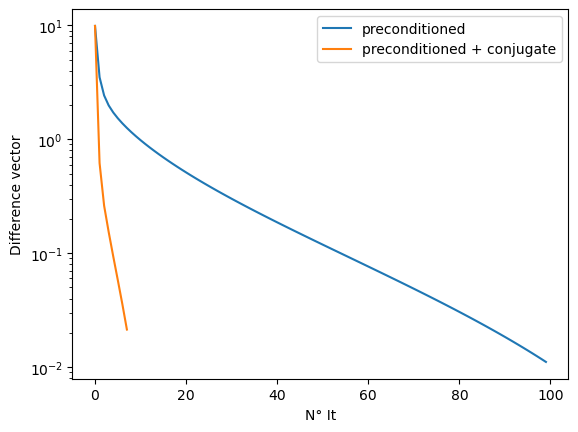

In [43]:
dV = np.sum(np.sum(np.sum((recItV[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_CG[:8,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)


#dV = np.sum(np.sum(np.sum((recItV_CG[:-4,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
# dV = np.sum(np.sum(np.sum((recItV_CG[:-20,:,:,:]-np.expand_dims(recItV_CG[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)

# dV = np.sum(np.sum(np.sum((recItV[:-120,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)
#dV = np.sum(np.sum(np.sum((recItV_CG[:-20,:,:,:]-np.expand_dims(recItV[-1,:,:,:],axis=0))**2,axis=-1),axis=-1),axis=-1)
#plt.plot(dV)
#plt.xlim(0,20)
#plt.ylim(1e-2,4)
plt.yscale('log')
plt.legend(['preconditioned','preconditioned + conjugate'])
plt.xlabel('N° It')
plt.ylabel('Difference vector')


In [45]:
np.save('ref_imm.npy',recItV_CG)

In [48]:
recItV_CG.nbytes/np.power(2,20)

1937.8662109375

In [50]:
np.save('recIt_diagPrecond.npy',recItV)

In [51]:
np.save('refImm.npy',recImmCG)

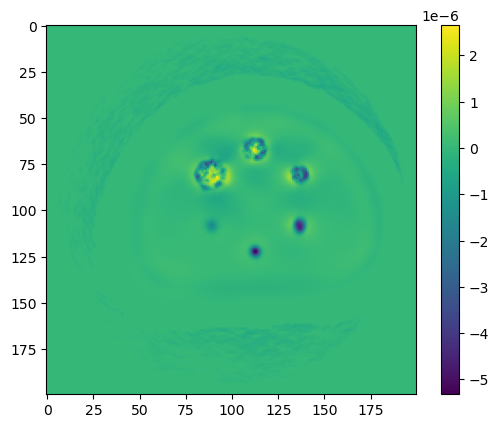

In [52]:
plt.imshow(ss*sDir.as_array()[72,:,:])
plt.colorbar()

/tmp/ipykernel_50445/1781100817.py:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
/tmp/ipykernel_50445/1781100817.py:5: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)


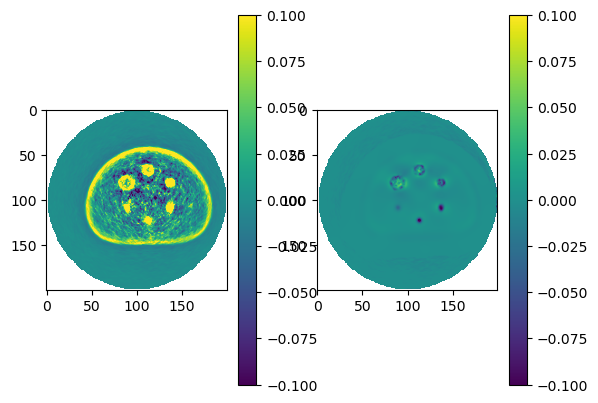

In [53]:
plt.subplot(121)
plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()

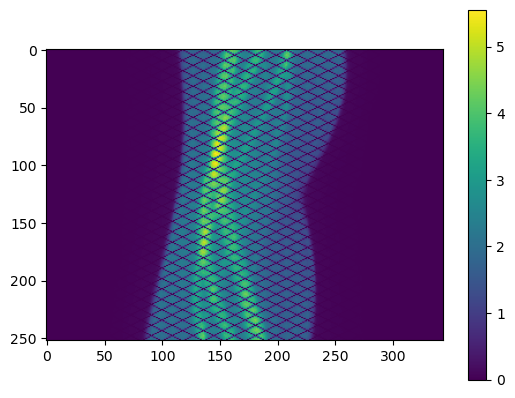

In [666]:
slIdx +=1
plt.imshow(tFP.as_array()[0,slIdx,:,:])
plt.colorbar()

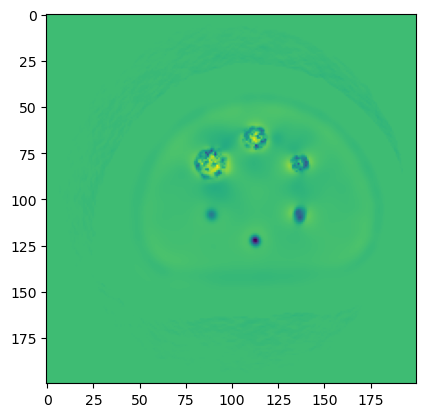

In [258]:
plt.imshow(sDir.as_array()[72,:,:]) #,vmax=400)

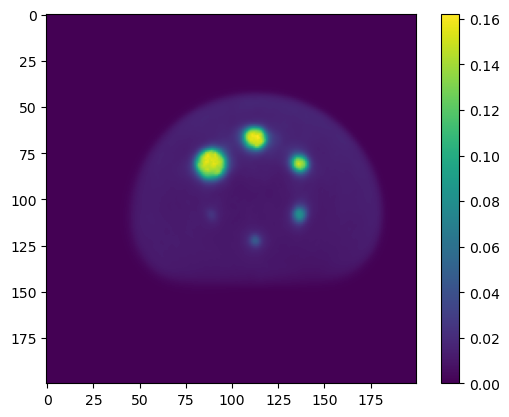

In [260]:
plt.imshow(image.as_array()[72,:,:]) #,vmax=.)
plt.colorbar()

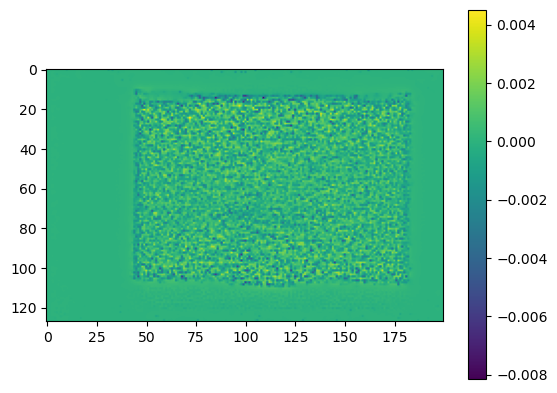

In [676]:
plt.imshow(recItV[18,:,100,:]-recItV[0,:,100,:])
plt.colorbar()

In [479]:
ss/ssDen

0.0

In [261]:
dV = np.sum(np.sum(np.sum(recItV-np.expand_dims(recItV[-1,:,:,:,],axis=0),axis=-1),axis=-1),axis=-1)**2
plt.plot(dV)

NameError: name 'recItV' is not defined

In [27]:
import scipy.ndimage as ndi

/tmp/ipykernel_11022/2359744373.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)


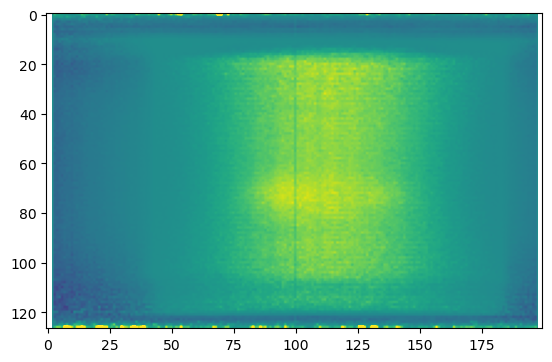

In [457]:
plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)
#plt.colorbar()

/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)


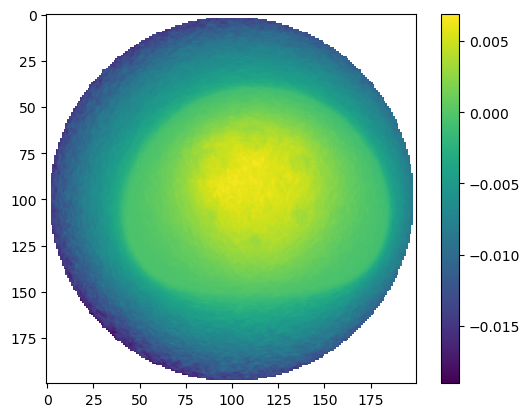

In [415]:

plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
plt.colorbar()

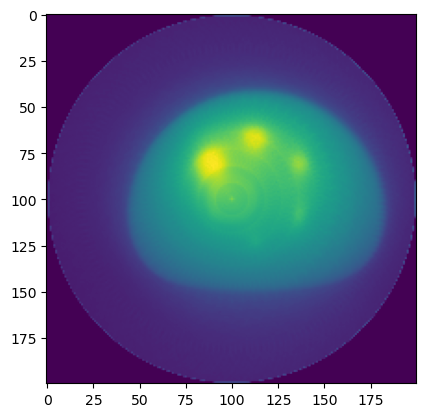

In [331]:
plt.imshow(bkwP.as_array()[72,:,:]/(kappa.as_array()[72,:,:]))